In [1]:
import numpy as np
import scipy
import poppy
if poppy.accel_math._USE_CUPY:
    import cupy as xp
    import cupyx.scipy as _scipy
else:
    xp = np
    _scipy = scipy
    
from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

# import zosapi
# from System import Enum,Int32,Double,Array
from pathlib import Path

from importlib import reload

# import logging, sys
# poppy_log = logging.getLogger('poppy')
# poppy_log.setLevel('DEBUG')
# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

# poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from prop_models import ote_model

from imshows import imshow1, imshow2, imshow3

pupil_diam = 6.5*u.m
wavelength_c = 650e-9*u.m

Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.
Oversampling > 2x suggested for reliable results in Fresnel propagation.


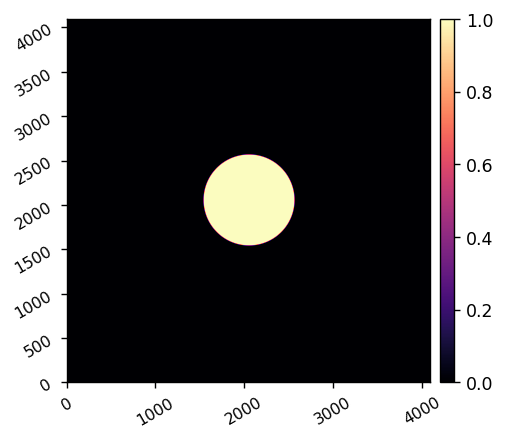

In [2]:
reload(ote_model)
ote = ote_model.OTE()

ote.npix = 1024
ote.oversample = 4

imshow1(ote.pupil_mask)

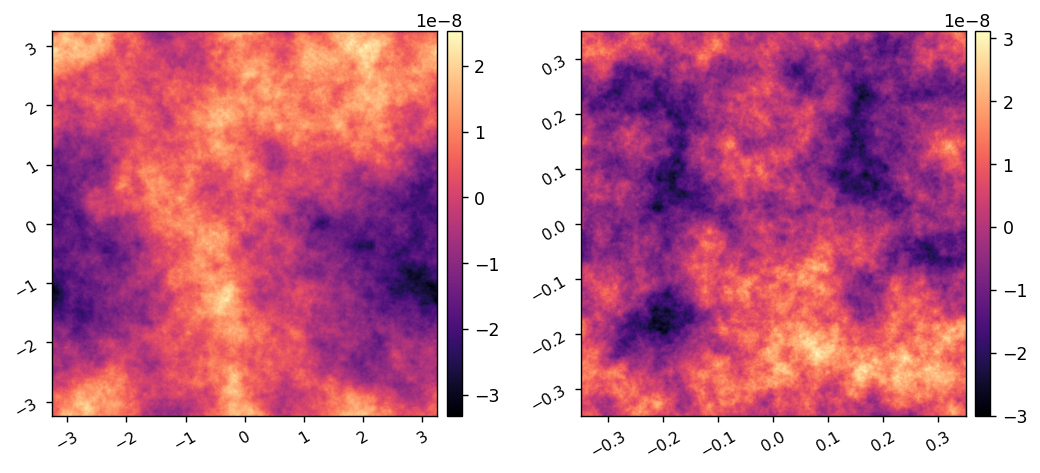

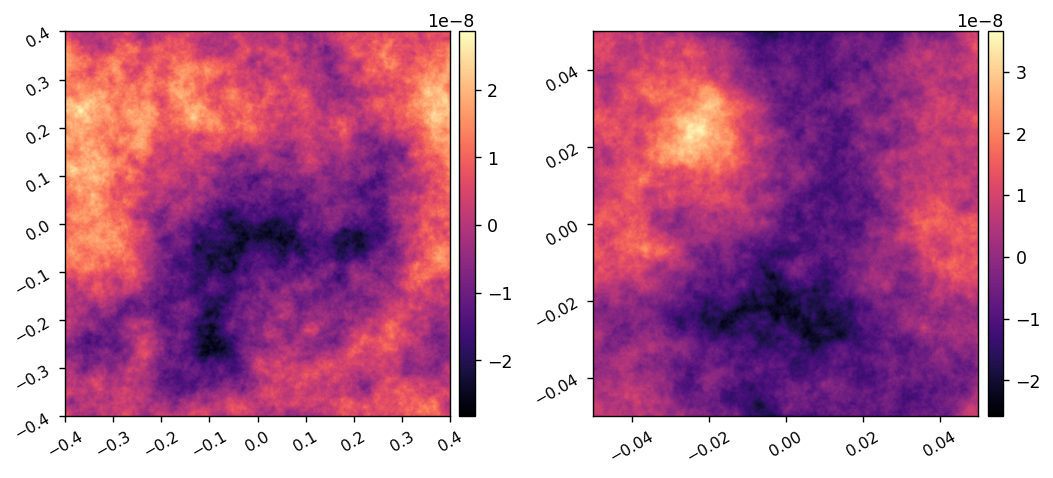

In [3]:
imshow2(ote.m1_opd.opd, ote.m2_opd.opd, 
        pxscl1=ote.m1_opd.pixelscale, pxscl2=ote.m2_opd.pixelscale)

imshow2(ote.m3_opd.opd, ote.m4_opd.opd, 
        pxscl1=ote.m3_opd.pixelscale, pxscl2=ote.m4_opd.pixelscale)

After resampling, optic phasor shape (1238, 1238) is smaller than input wavefront (4096, 4096); will zero-pad the rescaled array.
After resampling, optic phasor shape (1699, 1699) is smaller than input wavefront (4096, 4096); will zero-pad the rescaled array.


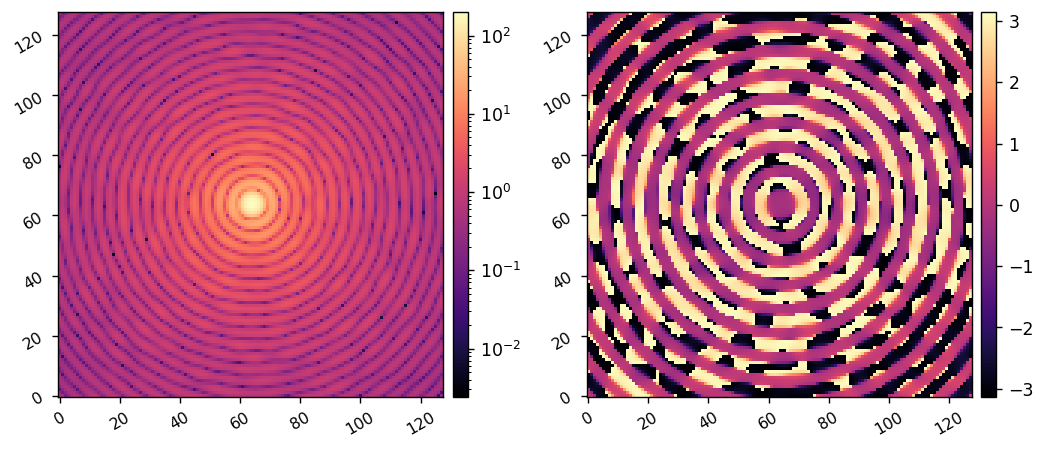

In [4]:
ote.defocus = -0.0*u.mm
psf = ote.calc_psf()
imshow2(xp.abs(psf), xp.angle(psf), lognorm1=True, npix=128)

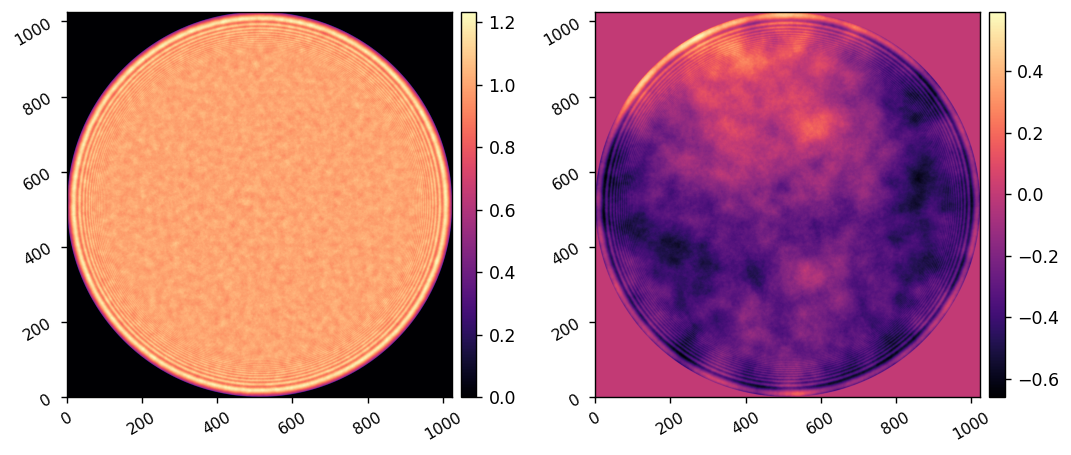

Saved data to:  ote-wfe-data/telescope_wfe.fits


In [6]:
import misc

pupil = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(psf))) / psf.shape[0]
pupil_amp = misc.pad_or_crop(xp.abs(pupil)*ote.pupil_mask, ote.npix)
pupil_phs = misc.pad_or_crop(xp.angle(pupil)*ote.pupil_mask, ote.npix)
pupil_opd = pupil_phs * wavelength_c.to_value(u.m)/(2*np.pi)
imshow2(pupil_amp, pupil_phs, npix=ote.npix)

dm_diam = 0.0102
data = ote_model.ensure_np_array(xp.array([pupil_amp,pupil_opd]))
misc.save_fits('ote-wfe-data/telescope_wfe.fits', data=data, header={'PIXELSCL':dm_diam/ote.npix})